# __Code Description__

1. Data Exploration<br>
      * Handle duplicates, empty values and outlier by removing rows<br>
      * Remove columns(attributes) that is not related with result('id')<br>
      * Normalize using StandardScaler [__Question 1__] and ai'= (ai - min(a))/(max(a)-min(a)) [__Question 2__]
      * Split the dataset into training data and test data (80/20)
        
2. Elbow Method<br>
      * Calculate Sum Square Error for each k values<br>
      * Plot [k vs Sum Square Error]<br>
      * Pick the best k
    
3. Train the K_mean classifier using training data<br>
      * [__Question 1__] : Built-in libarary (from sklearn)
      * [__Question 2__] : K-means algorithm from scratch
      
4. Predict the test data and calculate accuracy

#### Import libararies

In [130]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Iris data

In [157]:
df_iris = pd.read_csv(r'Iris.csv')
print(df_iris)
df_iris = df_iris.drop(columns=['Id'])
df_iris = df_iris.drop_duplicates(subset=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'], ignore_index=True)
print(df_iris)
df_iris = df_iris.dropna()
df_iris = df_iris.reset_index(drop=True)
print(df_iris)
z_score = st.zscore(df_iris.drop(columns=['Species']))

filtered = (np.abs(z_score)< 3).all(axis=1)
df_iris = df_iris[filtered].reset_index(drop=True)
print(df_iris)

      Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  

# Question 1

### Use sklearn.cluster library

#### Put all attributes on the same scale

In [132]:
iris_X = df_iris.drop(columns=['Species'])
iris_Y = df_iris['Species']
scaler = StandardScaler()
scaler.fit(iris_X)
iris_X = scaler.transform(iris_X)

#### Split Tarin(80)/Test(20)

In [133]:
iris_train_X, iris_test_X, iris_train_Y, iris_test_Y = train_test_split(iris_X, iris_Y, test_size=0.2, train_size=0.8, random_state=42)
df_train_X = pd.DataFrame(iris_train_X, columns=df_iris.drop(columns=['Species']).columns)
df_test_X = pd.DataFrame(iris_test_X, columns=df_iris.drop(columns=['Species']).columns)
df_train_Y = iris_train_Y.reset_index(drop=True)
df_test_Y = iris_test_Y.reset_index(drop=True)

#### Use sklearn.cluster.Kmeans

In [5]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_train_X)
df_cluster = pd.DataFrame({'Cluster':kmeans.labels_})
df_train_X.head()
df_cluster.head()

,Cluster
0,0
1,0
2,1
3,1
4,0


## Elbow method

 Function for calculating distance square between dataframe and one center

In [9]:
def error_square(df, center):
    df_sub = df-center
    df_sq = df_sub.mul(df_sub)
    return np.sum(df_sq.sum(axis=1))

Function for calculating sum of distance square between dataframe and all centers

In [10]:
def ErrorSquareSum(df, df_cluster, centers):
    uniques = np.unique(df_cluster)
    result = 0
    for cluster in range(len(uniques)):
        indices = df_cluster[df_cluster.Cluster == uniques[cluster]].index
        curr_df = df.loc[indices]
        result += error_square(curr_df, centers[cluster])
        
    return result

Function returns most frequent label/class in Series

In [11]:
def MostFrequentClass(targets):
    elements, num = np.unique(targets, return_counts=True)
    index = np.argmax(num)
    return elements[index]

Function returns the list of classes that matches to label number

In [12]:
def GetClusterLabel(df_cluster, df_train_Y):
    result = []
    uniques = np.unique(df_cluster)
    for cluster in range(len(uniques)):
        indices = df_cluster[df_cluster.Cluster == uniques[cluster]].index
        result.append(MostFrequentClass(df_train_Y.loc[indices]))
    return result

#### Calculate Sum of Square Error for each k 
* range of k : from 2 to length of train data

In [134]:
SSE = []
num_cluster = []
i = 1
while i <= 10:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_train_X)
    df_cluster = pd.DataFrame({'Cluster':kmeans.labels_})
    SSE.append(ErrorSquareSum(df_train_X, df_cluster, kmeans.cluster_centers_))
    num_cluster.append(i)
    
    i += 1

#### Plot [k vs Sum of Suqare Error]

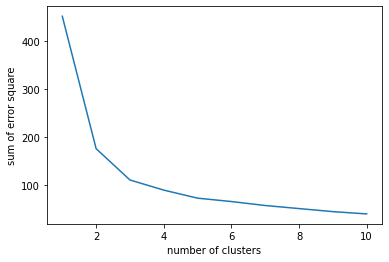

In [135]:
plt.plot(num_cluster, SSE)
plt.xlabel('number of clusters')
plt.ylabel('sum of error square')

plt.show()

#### Check accuracies between k=2 and k=25

In [15]:
accuracies = []
clusters = []
i = 2

while i <= 25:
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_train_X)
    df_cluster = pd.DataFrame({'Cluster':kmeans.labels_})
    labels = GetClusterLabel(df_cluster, df_train_Y)
    predicted = pd.Series(list(map(lambda x : labels[x], kmeans.predict(df_train_X))))
    compared = predicted.compare(df_train_Y)
    accuracies.append(1.0-len(compared)/len(df_train_Y))
    clusters.append(i)

    i += 1

df_accuracy = pd.DataFrame(data={'Accuracy':accuracies}, index=clusters)
print(df_accuracy)

    Accuracy
2   0.655172
3   0.818966
4   0.793103
5   0.801724
6   0.836207
7   0.810345
8   0.844828
9   0.931034
10  0.931034
11  0.922414
12  0.939655
13  0.965517
14  0.939655
15  0.948276
16  0.931034
17  0.956897
18  0.982759
19  0.965517
20  0.974138
21  0.931034
22  0.948276
23  0.965517
24  0.956897
25  0.965517


#### Pick the best k from above

In [16]:
best_k = df_accuracy.iloc[np.argmax(df_accuracy)].name
print(best_k)

18


#### Run k-means with best K and print accuracy

In [136]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train_X)
df_cluster = pd.DataFrame({'Cluster':kmeans.labels_})
labels = GetClusterLabel(df_cluster, df_train_Y)
predicted = pd.Series(list(map(lambda x : labels[x], kmeans.predict(df_test_X))))
compared = predicted.compare(df_test_Y)
accuracy = 1.0-len(compared)/len(df_test_Y)
print("Accuracy:",accuracy*100.0, '%')

Accuracy: 93.33333333333333 %


In [137]:
silhouette_score(df_train_X, kmeans.predict(df_train_X))

0.4452229046646433

# Question 2

## K-mean Algorithms from scratch

#### Squared Distance

In [138]:
def DistanceSquare(df, cluster):
    df_sub = df-cluster
    df_sq = df_sub.mul(df_sub)
    d = list(np.sum(df_sq, axis=1))
    return d

#### Implement K-mean++ 

In [139]:
def SelectInitialClusters(df, k):
    clusters = []
    initial_cluster = df.sample(random_state = 42)
    curr_index = initial_cluster.index[0]
    cluster = list(df.loc[curr_index])
    df = df.drop(curr_index)
    clusters.append(cluster)
    
    for i in range(k-1):
        d = DistanceSquare(df, cluster)
        curr_index = df.iloc[np.argmax(d)].name
        cluster = list(df.loc[curr_index])
        df = df.drop(curr_index)
        clusters.append(cluster)

    return clusters

#### Class for cluster information. It will be used in return value of K_means function

In [140]:
# clusters : all observations assigned to a cluster
# centroids : Coordinates of cluster centers
# SumSquareDistances : Sum of squared distances of samples to their closest cluster center
# labels : Class/Lables of each data point
# iterations : Number of iterations runs
class ClusterInfo:
    def __init__(self, errorsum_, iter_, centers_,labels_, clusters_):
        self.SumSquareDistances = errorsum_
        self.iterations = iter_
        self.centroids = centers_
        self.labels = labels_
        self.clusters = clusters_
    def predict_label(self, data):
        dists = pd.DataFrame(index = data.index)
        for c in range(len(self.centroids)):
            dists[c] = DistanceSquare(data, self.centroids[c])
        return pd.DataFrame({'Cluster':dists.idxmin(axis=1)})
    def predict_class(self, data, train_Y):
        labels = self.predict_label(data)
        classes = GetClusterLabel(self.labels, train_Y)
        return pd.DataFrame({'Cluster': list(map(lambda x : classes[x], labels['Cluster'].values.tolist()))}, index = data.index)

#### K-means Algorithm from scratch

In [150]:
def K_means(df, k, max_iter, initial_seeds):
        
    centers = initial_seeds
    cluster = pd.DataFrame({'Cluster':0}, index=df.index)
    curr_cluster = pd.DataFrame({'Cluster':0}, index=df.index)

    i = 0
    while i < max_iter:
        
        #Calculate distances for each centers
        distances = pd.DataFrame(index = df.index)
        for c in range(len(centers)):
            distances = pd.concat([distances, pd.DataFrame({c:DistanceSquare(df,centers[c])})], axis=1)
                
        #Pick clusters that have min distances and assign cluster 
        curr_cluster['Cluster'] = distances.idxmin(axis=1).values

        #check if there is no change on cluster assign
        if cluster['Cluster'].equals(curr_cluster['Cluster']):
            break
            
        cluster['Cluster'] = curr_cluster.values

        #Update new centers
        new_centers = []
        for j in range(k):
            indices = cluster[cluster.Cluster==j].index
            new_centers.append(df.loc[indices].mean(axis=0).values.tolist())
        
        centers = new_centers
        i += 1 
 
    #indices that each cluster has
    cluster_indices = pd.Series(dtype=object, index=range(k))
    for j in range(k):
        cluster_indices[j] = cluster[cluster.Cluster==j].index.values.tolist()
        
    return ClusterInfo(ErrorSquareSum(df, cluster, centers), i, centers, cluster, df)

### Data Exploration

 * Normalize : ai'= (ai - min(a))/(max(a)-min(a) 

In [78]:
def Normalize(data, target_name):
    result = pd.DataFrame({})
    for col in data.drop(columns=target_name).columns:
        max_value = data[col].max()
        min_value = data[col].min()
        normalized = (data[col]-min_value)/(max_value-min_value)
        result[col] = normalized
    result[target_name] = data[target_name]
    return result

In [79]:
df_iris = Normalize(df_iris,'Species')
df_iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,0.222222,0.681818,0.067797,0.041667,Iris-setosa
1,0.166667,0.454545,0.067797,0.041667,Iris-setosa
2,0.111111,0.545455,0.050847,0.041667,Iris-setosa
3,0.083333,0.500000,0.084746,0.041667,Iris-setosa
4,0.194444,0.727273,0.067797,0.041667,Iris-setosa


* Split data into training/test (80/20)

In [80]:
iris_train_X, iris_test_X, iris_train_Y, iris_test_Y = train_test_split(iris_X, iris_Y, test_size=0.2, train_size=0.8, random_state=42)
train_X = pd.DataFrame(iris_train_X, columns=df_iris.drop(columns=['Species']).columns)
test_X = pd.DataFrame(iris_test_X, columns=df_iris.drop(columns=['Species']).columns)
train_Y = iris_train_Y.reset_index(drop=True)
test_Y = iris_test_Y.reset_index(drop=True)

In [81]:
print(len(train_X))

116


#### Caculate Sum Squarer Error

In [151]:
SSE = []
num_cluster = []
i = 2
while i <= 10:
    initial = SelectInitialClusters(train_X,i)
    kmeans = K_means(train_X, i, 100, initial)
    SSE.append(kmeans.SumSquareDistances)
    num_cluster.append(i)
    
    i += 1

#### Plot [k vs Sum Square Error]

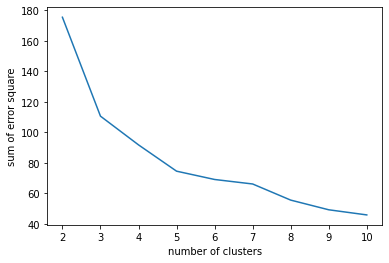

In [152]:
plt.plot(num_cluster, SSE)
plt.xlabel('number of clusters')
plt.ylabel('sum of error square')

plt.show()

#### Accuracies according to K and the number of iterations

In [124]:
i = 2
j_range = [2,5,8,12,14,16]
df_accuracy = pd.DataFrame(columns = j_range, index=clusters)

while i <= 20:
    initial = SelectInitialClusters(train_X, i)
    curr_accuracies = []
    for j in j_range:
        kmeans = K_means(train_X, i, j, initial)
        predicted = kmeans.predict_class(train_X, train_Y)
        compared = predicted['Cluster'].compare(train_Y)
        curr_accuracies.append(1.0-len(compared)/len(train_Y))
    
    df_accuracy.loc[i] = curr_accuracies
    i += 1

print(df_accuracy)
max_val = df_accuracy.stack().index[np.argmax(df_accuracy.values)]
best_k = max_val[0]
best_iterations = max_val[1]
print('Best k =', best_k)
print('Best iterations =', best_iterations)

          2         5         8         12        14        16
2   0.655172  0.655172  0.655172  0.655172  0.655172  0.655172
3   0.801724  0.810345  0.810345  0.810345  0.810345  0.810345
4   0.801724  0.793103  0.793103  0.793103  0.793103  0.793103
5   0.801724  0.836207  0.818966  0.793103  0.810345  0.810345
6   0.810345  0.827586  0.801724  0.810345  0.810345  0.810345
7   0.827586  0.818966  0.801724  0.801724  0.801724  0.801724
8   0.801724  0.810345  0.810345  0.810345  0.810345  0.810345
9   0.793103  0.810345  0.818966  0.818966  0.818966  0.818966
10  0.793103  0.818966  0.827586  0.827586  0.827586  0.827586
11  0.810345  0.818966  0.818966  0.818966  0.818966  0.818966
12  0.810345  0.818966  0.818966  0.818966  0.818966  0.818966
13  0.818966  0.810345  0.810345  0.810345  0.810345  0.810345
14  0.818966  0.810345  0.810345  0.810345  0.810345  0.810345
15   0.87069  0.922414  0.905172  0.905172  0.905172  0.905172
16   0.87069  0.922414  0.905172  0.905172  0.905172  0

#### Evaluate with best k value and best number of iterations

In [148]:
initial_centers = SelectInitialClusters(train_X, best_k)
km = K_means(train_X, 5, 100, initial_centers)

In [149]:
print('<Labels>\n',km.labels)
print('<SquareDistance Sum> :',km.SumSquareDistances)
print('<Total Iterations> :',km.iterations)
#print('Centers :',km.centroids)

classes = km.predict_class(test_X, train_Y)
print('<CLASSES>')
print(classes)

<Labels>
      Cluster
0          1
1          1
2          4
3          2
4          1
..       ...
111        4
112        2
113        1
114        0
115        2

[116 rows x 1 columns]
<SquareDistance Sum> : 74.47319878594199
<Total Iterations> : 16
<CLASSES>
            Cluster
0       Iris-setosa
1    Iris-virginica
2       Iris-setosa
3       Iris-setosa
4       Iris-setosa
5    Iris-virginica
6       Iris-setosa
7    Iris-virginica
8   Iris-versicolor
9       Iris-setosa
10      Iris-setosa
11   Iris-virginica
12   Iris-virginica
13  Iris-versicolor
14   Iris-virginica
15      Iris-setosa
16   Iris-virginica
17   Iris-virginica
18      Iris-setosa
19   Iris-virginica
20  Iris-versicolor
21   Iris-virginica
22      Iris-setosa
23   Iris-virginica
24      Iris-setosa
25  Iris-versicolor
26  Iris-versicolor
27   Iris-virginica
28   Iris-virginica
29      Iris-setosa


#### Accuracy

In [127]:
compared = classes['Cluster'].compare(test_Y)
accuracy = 1.0-len(compared)/len(test_Y)
print(accuracy)

0.9666666666666667


#### Silhouette Coefficient to measure the quality of clusters

In [128]:
def SilhouetteCoefficient(test_X, test_predicted):
    results = pd.DataFrame({'Silhouette': 0.0},index=test_X.index)
    clusters = np.unique(test_predicted)
    clusters.sort()
    center_list = []
    #calculate centers
    for c in clusters:
        indices = test_predicted[test_predicted.Cluster==c].index
        center_list.append(test_X.loc[indices].mean(axis=0).values.tolist())
    
    centers = pd.DataFrame(center_list, index = clusters)
    
    for c in range(len(clusters)):
        indices = test_predicted[test_predicted.Cluster == clusters[c]].index
        curr_df = test_X.loc[indices]

        #find nearest cluster
        curr_cluster = clusters[c]
        d_other_clusters = pd.Series(DistanceSquare(centers.drop(curr_cluster), centers.loc[curr_cluster].values), index=centers.drop(curr_cluster).index)
        next_cluster = d_other_clusters.idxmin()
        next_indices = test_predicted[test_predicted.Cluster == next_cluster].index
        next_df = test_X.loc[next_indices]
        
        for index in indices:
            if len(curr_df) == 1:
                a = 0
            else:
                #mean distance with all other points in the same class (a)
                a = np.mean(DistanceSquare(curr_df.drop(index), curr_df.loc[index].values))
            
            #mean distance with all other points in the next nearest cluster
            b = np.mean(DistanceSquare(next_df, curr_df.loc[index].values))
            results.loc[index] = [(b-a)/np.max([b,a])]
            
    return results

In [158]:
labels = km.predict_label(test_X)
s = SilhouetteCoefficient(test_X, labels)
print(s['Silhouette'].mean())

0.476922190872871
